In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Load and prepare data
print("Loading Drug-Induced Autoimmunity dataset...")
data = pd.read_csv('DRG.csv')
X = data.drop(['Label', 'SMILES'], axis=1)
y = data['Label']

print(f"Dataset: {data.shape[0]} compounds, {X.shape[1]} molecular descriptors")
print(f"Class distribution: {y.value_counts().to_dict()}")

Loading Drug-Induced Autoimmunity dataset...
Dataset: 477 compounds, 196 molecular descriptors
Class distribution: {0: 359, 1: 118}


In [3]:
# 2. Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# 3. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

In [5]:
# 4. Enhanced Model Setup
rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)

In [6]:
# 5. Enhanced Ensemble
ensemble = VotingClassifier([
    ('rf', rf_model),
    ('gb', gb_model), 
    ('xgb', xgb_model)
], voting='soft', weights=[0.4, 0.4, 0.2])

In [7]:
# 6. Train and evaluate individual models
print("\n=== INDIVIDUAL MODEL PERFORMANCE ===")
models = {'Random Forest': rf_model, 'Gradient Boosting': gb_model, 'XGBoost': xgb_model}
individual_results = {}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    individual_results[name] = {
        'auc': auc_score,
        'recall': report['1']['recall'],
        'precision': report['1']['precision'],
        'f1': report['1']['f1-score']
    }
    
    print(f"{name}:")
    print(f"  ROC-AUC: {auc_score:.3f}")
    print(f"  Recall: {report['1']['recall']:.3f}")
    print(f"  Precision: {report['1']['precision']:.3f}")
    print(f"  F1-Score: {report['1']['f1-score']:.3f}")



=== INDIVIDUAL MODEL PERFORMANCE ===
Random Forest:
  ROC-AUC: 0.875
  Recall: 0.542
  Precision: 0.684
  F1-Score: 0.605
Gradient Boosting:
  ROC-AUC: 0.885
  Recall: 0.667
  Precision: 0.640
  F1-Score: 0.653
XGBoost:
  ROC-AUC: 0.888
  Recall: 0.667
  Precision: 0.571
  F1-Score: 0.615


In [8]:
# 7. Train and evaluate ensemble
print("\n=== ENSEMBLE MODEL PERFORMANCE ===")
ensemble.fit(X_train_balanced, y_train_balanced)
ensemble_pred = ensemble.predict(X_test_scaled)
ensemble_proba = ensemble.predict_proba(X_test_scaled)[:, 1]


ensemble_auc = roc_auc_score(y_test, ensemble_proba)
ensemble_report = classification_report(y_test, ensemble_pred, output_dict=True)

print(f"Ensemble ROC-AUC: {ensemble_auc:.3f}")
print(f"Ensemble Recall: {ensemble_report['1']['recall']:.3f}")
print(f"Ensemble Precision: {ensemble_report['1']['precision']:.3f}")
print(f"Ensemble F1-Score: {ensemble_report['1']['f1-score']:.3f}")


=== ENSEMBLE MODEL PERFORMANCE ===
Ensemble ROC-AUC: 0.885
Ensemble Recall: 0.625
Ensemble Precision: 0.625
Ensemble F1-Score: 0.625


In [9]:
# 8. Cross-validation
cv_scores = cross_val_score(ensemble, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
print(f"\n5-Fold CV ROC-AUC: {cv_scores.mean():.3f} (±{cv_scores.std()*2:.3f})")


5-Fold CV ROC-AUC: 0.974 (±0.067)


Visualization

C:\Users\Asus\AppData\Local\Temp\ipykernel_11892\1831999261.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(models_list, rotation=45)


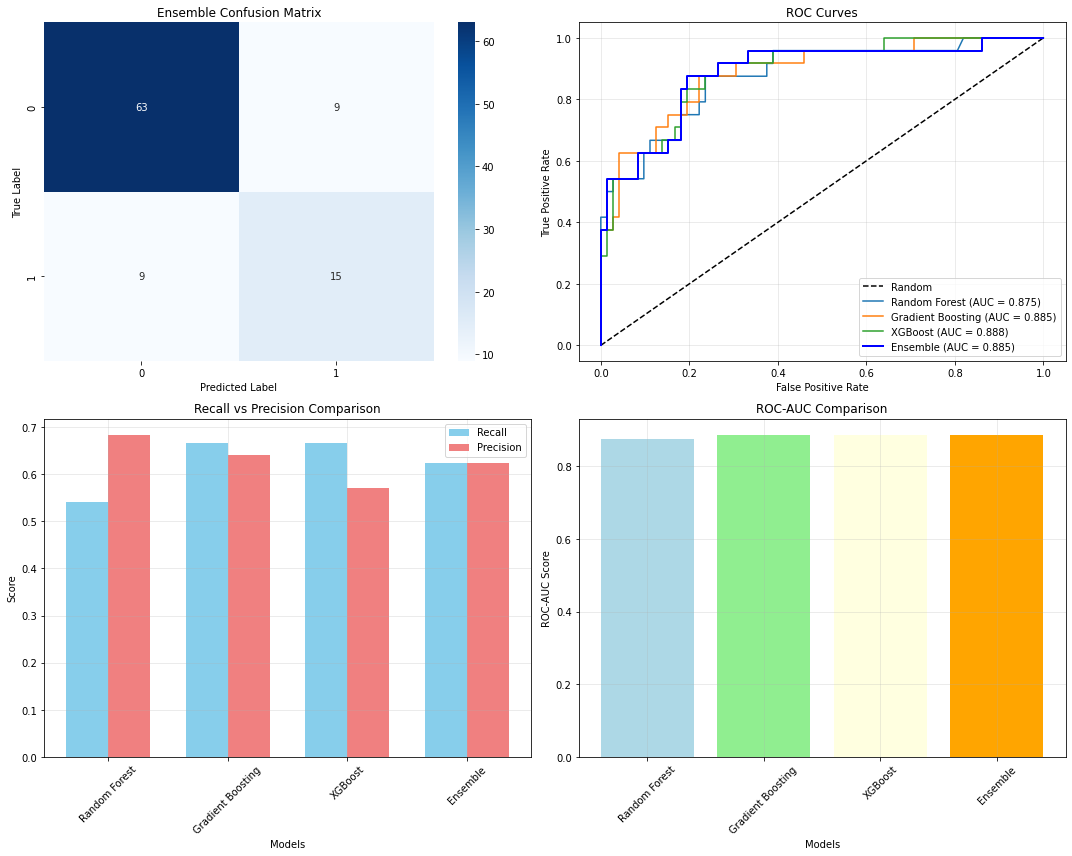

In [10]:
# 9. Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
cm = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Ensemble Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# ROC Curves
ax2.plot([0, 1], [0, 1], 'k--', label='Random')
for name, model in models.items():
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    ax2.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, ensemble_proba)
ax2.plot(fpr_ensemble, tpr_ensemble, 'b-', linewidth=2, label=f'Ensemble (AUC = {ensemble_auc:.3f})')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)


# Performance Comparison
models_list = list(individual_results.keys()) + ['Ensemble']
recalls = [individual_results[m]['recall'] for m in individual_results.keys()] + [ensemble_report['1']['recall']]
precisions = [individual_results[m]['precision'] for m in individual_results.keys()] + [ensemble_report['1']['precision']]

x = np.arange(len(models_list))
width = 0.35
ax3.bar(x - width/2, recalls, width, label='Recall', color='skyblue')
ax3.bar(x + width/2, precisions, width, label='Precision', color='lightcoral')
ax3.set_xlabel('Models')
ax3.set_ylabel('Score')
ax3.set_title('Recall vs Precision Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(models_list, rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3)

# AUC Comparison
aucs = [individual_results[m]['auc'] for m in individual_results.keys()] + [ensemble_auc]
ax4.bar(models_list, aucs, color=['lightblue', 'lightgreen', 'lightyellow', 'orange'])
ax4.set_xlabel('Models')
ax4.set_ylabel('ROC-AUC Score')
ax4.set_title('ROC-AUC Comparison')
ax4.set_xticklabels(models_list, rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# 10. Summary for poster
print("\n=== SUMMARY FOR POSTER ===")
print("Enhanced Ensemble Model for Drug-Induced Autoimmunity Prediction")
print(f"Dataset: {data.shape[0]} compounds, {X.shape[1]} molecular descriptors")
print(f"Best Individual Model: {max(individual_results.items(), key=lambda x: x[1]['auc'])[0]}")
print(f"Ensemble ROC-AUC: {ensemble_auc:.3f}")
print(f"Ensemble Recall: {ensemble_report['1']['recall']:.3f}")
print(f"Cross-validation: {cv_scores.mean():.3f} ± {cv_scores.std()*2:.3f}")



=== SUMMARY FOR POSTER ===
Enhanced Ensemble Model for Drug-Induced Autoimmunity Prediction
Dataset: 477 compounds, 196 molecular descriptors
Best Individual Model: XGBoost
Ensemble ROC-AUC: 0.885
Ensemble Recall: 0.625
Cross-validation: 0.974 ± 0.067


In [12]:
# 11. Literature comparison
print("\n=== LITERATURE COMPARISON ===")
print("Our Enhanced Ensemble Results:")
print(f"  ROC-AUC: {ensemble_auc:.3f}")
print(f"  Recall: {ensemble_report['1']['recall']:.3f}")
print(f"  Precision: {ensemble_report['1']['precision']:.3f}")
print(f"  F1-Score: {ensemble_report['1']['f1-score']:.3f}")
print("\nCompare with literature:")
print("- Wu et al. (2021): Structural alerts + daily dose")
print("- Huang et al. (2025): InterDIA ensemble method")
print("- Takefuji (2025): Feature importance analysis")


=== LITERATURE COMPARISON ===
Our Enhanced Ensemble Results:
  ROC-AUC: 0.885
  Recall: 0.625
  Precision: 0.625
  F1-Score: 0.625

Compare with literature:
- Wu et al. (2021): Structural alerts + daily dose
- Huang et al. (2025): InterDIA ensemble method
- Takefuji (2025): Feature importance analysis
